In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import yaml

import mscproject.models as mod
import mscproject.experiment as exp

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

In [2]:
# Matplotlib Settings
plt.style.use("seaborn-whitegrid")
plt.style.use("seaborn-paper")

FONT_SIZE = 12

# Set plot font size
plt.rcParams.update({"font.size": 8})

# Set axis label font size
plt.rcParams.update({"axes.labelsize": 10})

# Set legend font size
plt.rcParams.update({"legend.fontsize": 10})

# Set tick label font size
plt.rcParams.update({"xtick.labelsize": 9})

# Set tick label font size
plt.rcParams.update({"ytick.labelsize": 9})

# Set figure title font size
plt.rcParams.update({"axes.titlesize": FONT_SIZE})

# Set legend face and edge color
plt.rcParams.update({"legend.facecolor": "white"})
plt.rcParams.update({"legend.edgecolor": "white"})
plt.rcParams.update({"legend.framealpha": 1})

In [3]:
conf_dict = yaml.safe_load(Path("config/conf.yaml").read_text())

In [4]:
edges_pre_df = pd.read_parquet(conf_dict["edges"])

In [5]:
edges_post_df = pd.read_parquet(conf_dict["edges_anomalies"])

## Graph Statistics

In [6]:
edges_post_df.is_anomalous.value_counts(normalize=True)

False    0.909235
True     0.090765
Name: is_anomalous, dtype: float64

<AxesSubplot:ylabel='Frequency'>

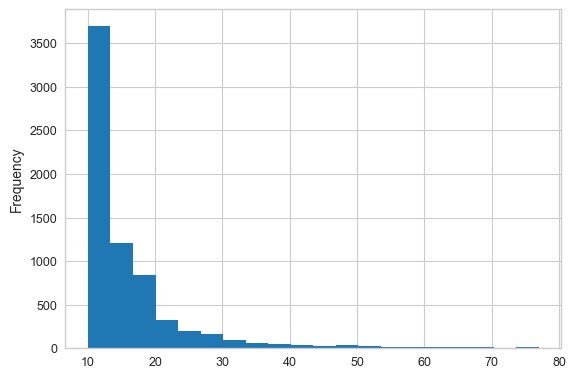

In [7]:
# Get component sizes
component_sizes_pre = edges_pre_df.groupby("component").agg({"src": "count"})
# Select 99% of components
component_sizes_pre = component_sizes_pre.sort_values("src", ascending=True).query(
    "src > 9"
)
component_sizes_pre = component_sizes_pre.iloc[: int(len(component_sizes_pre) * 0.99)]
component_sizes_pre["src"].plot.hist(bins=20, label="Normal")

In [8]:
graph_post = nx.from_pandas_edgelist(edges_post_df, "src", "dst")

In [9]:
# # Get connected components
# components_post = list(nx.connected_components(graph_post))
# # Assign components to edges
# edges_post_df["component"] = edges_post_df["src"].apply(
#     lambda x: [i for i, c in enumerate(components_post) if x in c][0]
# )

<AxesSubplot:ylabel='Frequency'>

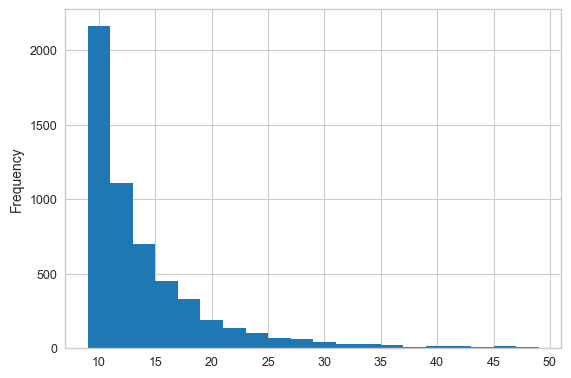

In [10]:
# Get component sizes
component_sizes_post = edges_post_df.groupby("component").agg(
    {"is_anomalous": "sum", "src": "count"}
)
# Select 99% of components
component_sizes_post = component_sizes_post.sort_values("src", ascending=True)
component_sizes_post = component_sizes_post.iloc[
    : int(len(component_sizes_post) * 0.99)
]
component_sizes_post["src"].plot.hist(bins=20, label="Normal")

In [39]:
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale('log')

In [83]:
edges_post_df

,component,src,dst,interestedPartyIsPerson,minimumShare,is_anomalous
0,0,2356236782051912119,3732317247976753020,True,75.0,False
1,0,2356236782051912119,14047622054401208865,True,75.0,False
2,0,692314493058510508,390416379365304942,True,25.0,False
3,0,15829769449001705952,3732317247976753020,True,75.0,False
4,0,15829769449001705952,17654996330473534901,True,75.0,False
...,...,...,...,...,...,...
131896,6863,18192837036067908255,15233613116661558738,True,25.0,False
131897,6863,18168561485814806981,7879326061664287605,True,25.0,False
131898,6863,2056455430524085329,7879326061664287605,True,25.0,False
131899,6863,15391449340824074448,15233613116661558738,True,25.0,False


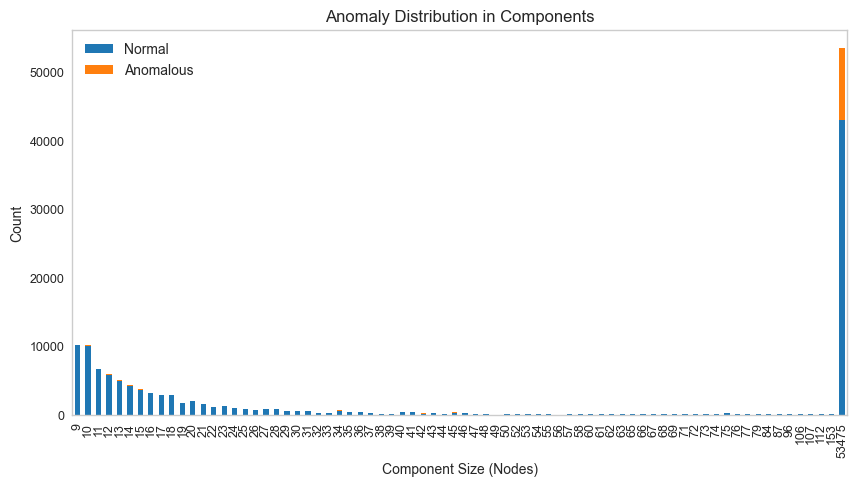

In [121]:
# Get component sizes
component_sizes_post = edges_post_df.groupby(["component", "is_anomalous"]).size()
component_sizes_post = component_sizes_post.unstack().fillna(0)
component_sizes_post["Total"] = component_sizes_post.sum(axis=1).astype(int)
component_sizes_post = component_sizes_post.sort_values("Total", ascending=True)
component_sizes_post = component_sizes_post.reset_index().rename(columns={False: "Normal", True: "Anomalous"})
ax = component_sizes_post.groupby("Total")[["Normal", "Anomalous"]].sum().plot.bar(stacked=True, figsize=(10, 5), logy=False)
ax.set_title("Anomaly Distribution in Components")
ax.set_xlabel("Component Size (Nodes)")
ax.set_ylabel("Count")
ax.grid(False)
# Remove legend title
ax.legend().set_title(None)

In [ ]:

component_sizes_post["has_anomaly"] = component_sizes_post["is_anomalous"] > 0
component_sizes_post = component_sizes_post.rename(columns={"src": "size"})
# Select 99% of components
component_sizes_post = component_sizes_post.sort_values("size", ascending=True)
# component_sizes_post = component_sizes_post.iloc[
#     : int(len(component_sizes_post) * 0.99)
# ]
anomaly_dist = component_sizes_post.groupby(["size", "has_anomaly"]).count().unstack().reset_index()
anomaly_dist["proportion_anomalous"] = (anomaly_dist["is_anomalous"][True] / (
    anomaly_dist["is_anomalous"][True] + anomaly_dist["is_anomalous"][False]
)).astype(float)
anomaly_dist = anomaly_dist.fillna(0)
anomaly_dist.plot.bar(x="size", y="proportion_anomalous")

In [82]:
anomaly_dist

size is_anomalous       proportion_anomalous
has_anomaly               False  True                     
0                9       1074.0  66.0             0.057895
1               10        932.0  93.0             0.090732
2               11        548.0  65.0             0.106036
3               12        448.0  48.0             0.096774
4               13        349.0  38.0             0.098191
..             ...          ...   ...                  ...
69             106          0.0   1.0             0.000000
70             107          0.0   1.0             0.000000
71             112          0.0   1.0             0.000000
72             153          1.0   0.0             0.000000
73           53475          0.0   1.0             0.000000

[74 rows x 4 columns]

In [65]:
anomaly_dist["is_anomalous"].reset_index()

has_anomaly,index,False,True
0,0,1074.0,66.0
1,1,932.0,93.0
2,2,548.0,65.0
3,3,448.0,48.0
4,4,349.0,38.0
...,...,...,...
69,69,0.0,1.0
70,70,0.0,1.0
71,71,0.0,1.0
72,72,1.0,0.0


In [44]:
anomaly_dist

is_anomalous      
has_anomaly        False  True
src                           
9                 1074.0  66.0
10                 932.0  93.0
11                 548.0  65.0
12                 448.0  48.0
13                 349.0  38.0
...                  ...   ...
106                  NaN   1.0
107                  NaN   1.0
112                  NaN   1.0
153                  1.0   NaN
53475                NaN   1.0

[74 rows x 2 columns]

In [ ]:

# Use default color cycle
# ax = anomaly_dist.plot.bar(stacked=False, alpha=1, label="Normal")
# ax = anomaly_dist.plot.hist(alpha=0.4, label="Normal", density=True, logx=True)
ax = anomaly_dist.plot.bar(alpha=0.4, label="Normal", logx=True)
ax.set_title("Anomaly Distribution by Component Size")
ax.set_xlabel("# Nodes")
ax.set_ylabel("Density")
# Set legend labels
ax.legend(["No Anomaly", "Anomaly"])
ax.grid(False)


In [12]:
component_sizes_post

,is_anomalous,src,has_anomaly
component,,,
6863,0,9,False
1183,0,9,False
1182,0,9,False
1181,0,9,False
3971,0,9,False
...,...,...,...
26,24,106,True
2558,2,107,True
948,2,112,True


In [13]:
component_sizes_pre.groupby("src").size().sort_index()[:20]

src
10    1417
11     952
12     764
13     570
14     493
15     396
16     324
17     268
18     245
19     171
20     155
21     139
22      97
23      84
24      79
25      64
26      52
27      53
28      47
29      36
dtype: int64

In [14]:
component_sizes_post.groupby("src").size().sort_index()[:20]

src
9     1140
10    1025
11     613
12     496
13     387
14     310
15     248
16     204
17     169
18     161
19      92
20     100
21      79
22      54
23      57
24      42
25      36
26      30
27      32
28      31
dtype: int64

In [15]:
component_sizes_post.groupby("src").agg(["sum", "count"])

is_anomalous       has_anomaly      
               sum count         sum count
src                                       
9               89  1140          66  1140
10             131  1025          93  1025
11             109   613          65   613
12              78   496          48   496
13              67   387          38   387
...            ...   ...         ...   ...
106             24     1           1     1
107              2     1           1     1
112              2     1           1     1
153              0     1           0     1
53475        10427     1           1     1

[74 rows x 4 columns]

## Anomaly Simulation

In [16]:
graph_edges_post = edges_post_df.query("component == 23")
graph_edges_post

,component,src,dst,interestedPartyIsPerson,minimumShare,is_anomalous
325,23,2258222399048453312,11395388473527546194,False,75.0,True
3488,23,7777674229742200955,2993799137589768883,False,75.0,False
3489,23,7777674229742200955,3121981569988026883,False,75.0,False
3490,23,7777674229742200955,3436044742148301739,False,75.0,False
3492,23,15507582945687881946,15327826988772839815,False,75.0,False
3494,23,7777674229742200955,16269176336766539906,False,75.0,False
3495,23,7777674229742200955,15507582945687881946,False,75.0,False
3496,23,7777674229742200955,9750640700739922330,False,75.0,False
3498,23,7777674229742200955,16288797838414460695,False,75.0,False
3499,23,7777674229742200955,16807511370466429520,False,75.0,False


In [17]:
edges_pre_df.query("src == '2258222399048453312'")

,component,src,dst,interestedPartyIsPerson,minimumShare
3551,77309426934,2258222399048453312,17957350210417364187,False,25.0


In [18]:
graph_edges_pre = edges_pre_df.query("component == 77309426934").sort_values("src")

In [19]:
edges_in_pre_not_in_post = graph_edges_pre.query(
    "src not in @graph_edges_post.src.values"
)
edges_in_pre_not_in_post

,component,src,dst,interestedPartyIsPerson,minimumShare
3558,77309426934,12193340053346509882,5906392310761780345,True,25.0
3547,77309426934,14144852946696025909,17957350210417364187,True,50.0
3555,77309426934,14144852946696025909,5906392310761780345,True,25.0
3545,77309426934,4875486011478224347,5906392310761780345,True,25.0


In [20]:
graph_pre = nx.DiGraph()
graph_pre.add_nodes_from(graph_edges_pre["src"].unique())
graph_pre.add_nodes_from(graph_edges_pre["dst"].unique())
graph_pre.add_edges_from(graph_edges_pre[["src", "dst"]].values)

In [21]:
graph_post = nx.DiGraph()
graph_post.add_nodes_from(graph_edges_post["src"].unique())
graph_post.add_nodes_from(graph_edges_post["dst"].unique())
graph_post.add_edges_from(graph_edges_post[["src", "dst"]].values)

In [22]:
node_c = "lightblue"
new_node_c = "lightgreen"
dropped_node_c = "lightpink"
anomalous_node_c = "darkorange"

edge_c = "lightgrey"
new_edge_c = "green"
dropped_edge_c = "red"

# new_edge_c = edge_c
# dropped_edge_c = edge_c

In [23]:
graph_pre.nodes

NodeView(('12193340053346509882', '14144852946696025909', '15507582945687881946', '2258222399048453312', '4875486011478224347', '7777674229742200955', '5906392310761780345', '17957350210417364187', '15327826988772839815', '11801961692943090600', '8939346425478313301', '9133034333592821249', '16807511370466429520', '2993799137589768883', '13900102674092328292', '9750640700739922330', '16269176336766539906', '3436044742148301739', '3121981569988026883', '16288797838414460695'))

In [24]:
i = 168
print(i)
pos = nx.drawing.spring_layout(graph_pre, seed=i, iterations=100, k=0.8)

NODE_SIZE = 100

168


In [25]:
anomaly_id = "2258222399048453312"
pos[anomaly_id] = [-0.40, 0.21]

In [26]:
def plot_pre(ax):

    edge_colours = [edge_c for u, v in graph_pre.edges]
    node_colours = [node_c for n in graph_pre.nodes]

    # pos = nx.drawing.spring_layout(graph_intermediate, iterations=1000, seed=i)
    nx.draw(
        graph_pre,
        pos=pos,
        edge_color=edge_colours,
        node_color=node_colours,
        # labels={n: n[:3] for n in graph_pre.nodes},
        node_size=NODE_SIZE,
        # font_size=8,
        # font_color="black",
        ax=ax,
    )

In [27]:
def plot_mid(ax):
    # Colour edges that are in the pre graph but not in the post graph
    edge_colours = [
        dropped_edge_c if (u) == "2258222399048453312" else edge_c
        for u, v in graph_pre.edges
    ]
    node_colours = [
        node_c if n in graph_post.nodes else dropped_node_c for n in graph_pre.nodes
    ]

    # Set colour for node 225
    idx = next(i for i, j in enumerate(graph_pre.nodes) if j == "2258222399048453312")
    node_colours[idx] = anomalous_node_c

    # pos = nx.drawing.spring_layout(graph_intermediate, iterations=1000, seed=i)
    nx.draw(
        graph_pre,
        pos=pos,
        edge_color=edge_colours,
        node_color=node_colours,
        # labels={n: n[:3] for n in graph_pre.nodes},
        node_size=NODE_SIZE,
        # font_size=8,
        # font_color="black",
        ax=ax,
    )

In [28]:
def plot_post(ax):
    pos2 = {**pos, "11395388473527546194": pos["17957350210417364187"]}

    # Colour edges in the post graph that are not in the pre graph
    edge_colours = [
        new_edge_c if u == "2258222399048453312" else edge_c
        for u, v in graph_post.edges
    ]
    node_colours = [
        node_c if n in graph_pre.nodes else new_node_c for n in graph_post.nodes
    ]

    # Set colour for node 225
    idx = next(i for i, j in enumerate(graph_post.nodes) if j == "2258222399048453312")
    node_colours[idx] = anomalous_node_c

    # pos = nx.drawing.spring_layout(graph_intermediate, iterations=1000, seed=i)
    nx.draw(
        graph_post,
        pos=pos2,
        edge_color=edge_colours,
        node_color=node_colours,
        # labels={n: n[:3] for n in graph_post.nodes},
        node_size=NODE_SIZE,
        # font_size=8,
        # font_color="black",
        ax=ax,
    )

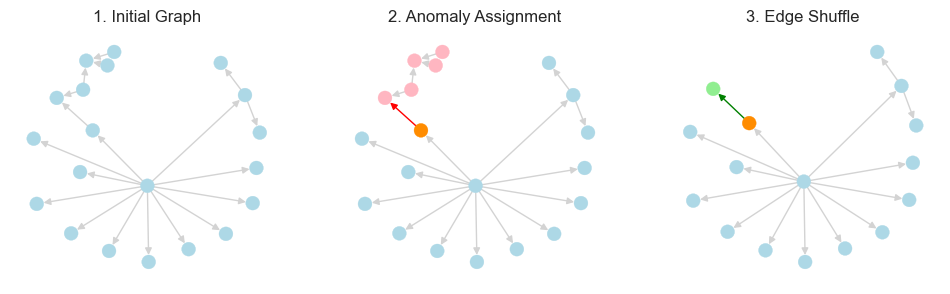

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3.3))
axes[0].set_title("1. Initial Graph")
axes[1].set_title("2. Anomaly Assignment")
axes[2].set_title("3. Edge Shuffle")

plot_pre(axes[0])
plot_mid(axes[1])
plot_post(axes[2])

fig.savefig("figures/anomaly-simulation.png", dpi=300, bbox_inches="tight")